In [1]:
seed = 0
import random
import numpy as np
import tensorflow as tf
import os
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
#     except RuntimeError as e:
#         print(e)

In [2]:
import numpy as np
import pandas as pd
# 选择比较好的模型
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.preprocessing import StandardScaler,MinMaxScaler
%load_ext autoreload
%autoreload 2

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
        '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
        '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

sample_num = 60

In [3]:
!ls ../../data/final_data

sensor_test_final.csv  sensor_train_final.csv  submit_example.csv


In [4]:
root_path  = '../../data/final_data/'
train = pd.read_csv(root_path+'sensor_train_final.csv')
test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [5]:


def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df
train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy',
       'xy_g', 'g'],
      dtype='object')


In [6]:
# # 原始的顺序
# # ['acc_x', 'acc_y', 'acc_z', 'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy', 'xy_g', 'g']

# group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
# print(group1)

# train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
# test = test[['fragment_id', 'time_point']+group1]

# 新的顺序
group1 = [ 'acc', 'accg', 'acc_x', 'acc_y', 'acc_z', 'acc_xg', 'acc_yg', 'acc_zg', 'thetax', 'thetay', 'thetaz', 'xy', 'xy_g', 'g']

train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
test = test[['fragment_id', 'time_point']+group1]

In [7]:
FEATURE_NUM=14

In [8]:
len(set(train['fragment_id'])),len(set(test['fragment_id']))

(15000, 16000)

In [9]:

x = np.zeros((15000, sample_num, FEATURE_NUM, 1))
t = np.zeros((16000, sample_num, FEATURE_NUM, 1))

In [10]:
def df2array(df,num,x):
    for i in tqdm(range(num)):
        tmp = df[df.fragment_id == i][:sample_num]
        length=len(tmp)
        if length<50:
            new_tmp=tmp.copy()
            while len(tmp)<60:
                new_tmp['time_point']=tmp['time_point'].max()+new_tmp['time_point']
                tmp=pd.concat([tmp,new_tmp],ignore_index=True)
        tmp=tmp.iloc[:60,:]
        x[i,:,:,0] = resample(tmp[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)
    return x
x=df2array(train,15000,x)
t=df2array(test,16000,t)

100%|██████████| 16000/16000 [01:12<00:00, 222.08it/s]


In [11]:
x.shape,t.shape

((15000, 60, 14, 1), (16000, 60, 14, 1))

In [12]:
%%time
# 一个完成了的generator
def data_generator(data,label,class17label,batch_size):
    """
    data:array  (7292, 60, 14, 1)
    label:array (7292,)
    class17label: series
    """
    class17label=np.asarray(class17label)
    length=len(data)
    seq_length=len(data[0])
    half_seq_length=int(seq_length/2)
    
    # index2label
    index2label=dict(zip(range(length),class17label))
    
    label2index={}
#     print(class17label)
    for i in range(length):
#         print(class17label[i],label2index.get(class17label[i],[]))
        label2index[class17label[i]]=label2index.get(class17label[i],[])
        label2index[class17label[i]].append(i)

    count=0
    np.random.seed(seed)# 保证结果可重复
    
    while True:
        
        if count==0 or (count + 1) * batch_size > length:  # 如果是第一个或者最后一个batch
            count=0
            shuffle_index = list(range(length))
            np.random.shuffle(shuffle_index)   ## 对索引进行打乱
        
        start = count * batch_size  ## batch的起始点
        end = (count + 1) * batch_size ## batch的终点
        inds=shuffle_index[start:end]

        count+=1
        
        if random.choice([0,1,1,1]):
            # minxup
            #one specific index -> label -> all the index belong to this
            choice_index=[random.choice(label2index[index2label[x]]) for x in inds]   # get the random choice seq(waiting for concat)
            # 1st 前1/2 seq_length 点原始  后1/2 seq_length 点随机
            res_x_orig=data[inds,:half_seq_length]   #原始
            res_x=data[choice_index,half_seq_length:]   #需要加入的

    #         print(inds)
    #         print(data.shape,res_x_orig.shape,res_x.shape,np.concatenate((res_x_orig,res_x),axis=1).shape)
            aaa=np.concatenate((res_x_orig,res_x),axis=1)
            yield [aaa[:,:,:8,:],aaa[:,:,2:,:]], [label[0][inds],label[1][inds],label[2][inds]]
        else:
        
            yield [data[inds][:,:,:8,:],data[inds][:,:,2:,:]],[label[0][inds],label[1][inds],label[2][inds]]
            
    

count=0
for a,b in data_generator(x,[y,y,y],y,32):
    print(a[0].shape,a[1].shape,b[0].shape)
    print('pppp')
    count+=1
    if count==20:
        break


(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
(32, 60, 8, 1) (32, 60, 12, 1) (32,)
pppp
CPU times: user 46.7 ms, sys: 5.05 ms, total: 51.7 ms
Wall time: 47.3 ms


In [13]:
def ConvBNRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
#                activation='relu',
               use_bias=False,
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X


def ConvRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
               activation='relu',
               use_bias=False,
               padding='same')(X)
    return X



def lenet5(input):
    A = ConvBNRelu(input,64,kernal_size=(3,3))
#     B = ConvBNRelu(input,16,kernal_size=(5,1))
#     C = ConvBNRelu(input,16,kernal_size=(7,1))
#     ABC = layers.Concatenate()([A,B,C])
    X = ConvBNRelu(A,128)
#     X = squeeze_excitation_layer(X,128)
    X = Dropout(0.2)(X)

    X = AveragePooling2D()(X)
    
    X = ConvBNRelu(X,256)
    X = Dropout(0.3)(X)
#     X = squeeze_excitation_layer(X,256)
    X = ConvBNRelu(X,512)   
    X = Dropout(0.5)(X)
#     X = squeeze_excitation_layer(X,512)
#     X = GlobalMaxPooling2D()(X)
    X = GlobalAveragePooling2D()(X)
    
#     X = BatchNormalization()(X)
    return X
import tensorflow as tf
def Net(sample_num):
    input1 = Input(shape=(sample_num, 6+2, 1))
    input2 = Input(shape=(sample_num, 6+6, 1))
    
    #######loss1
    X1 = lenet5(input1)
    X1 = BatchNormalization()(X1)
    X1 = Dense(128, activation='relu')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dropout(0.2)(X1)

    X2 = lenet5(input2)    
    X2 = BatchNormalization()(X2)
#     X = Dense(512, activation='relu')(X)
#     X = BatchNormalization()(X)
    X2 = Dense(128, activation='relu')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Dropout(0.2)(X2)
    X12 = Concatenate(axis=-1)([X1,X2])
    
    output1 = Dense(8, activation='softmax', name='4class')(X12)   # 大类-字母
    
    #######loss2
    X3 = lenet5(input1)
    X3 = BatchNormalization()(X3)
    X3 = Dense(128, activation='relu')(X3)
    X3 = BatchNormalization()(X3)
    X3 = Dropout(0.2)(X3)

    X4 = lenet5(input2)    
    X4 = BatchNormalization()(X4)
#     X = Dense(512, activation='relu')(X)
#     X = BatchNormalization()(X)
    X4 = Dense(128, activation='relu')(X4)
    X4 = BatchNormalization()(X4)
    X4 = Dropout(0.2)(X4)
    
    X34 = Concatenate(axis=-1)([X3,X4])
    
    output2 = Dense(10, activation='softmax', name='7class')(X34)   # 大类-数字
    
    X = Concatenate(axis=-1)([X12,X34])
    
    X = Dense(64)(X)
    output3 = Dense(20, activation='softmax',name='19class')(X) #小类
    
    
    return Model([input1,input2], [output1,output2,output3])

# model = Net(60)
# model.summary()

In [14]:
# 两个输出    
mapping = {
    '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
    '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
    '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
          }

# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}

from sklearn.utils.class_weight import compute_class_weight
# # y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights1=compute_class_weight("balanced",['A','B','C','D','E','F','G','H'],\
                                   pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'].apply(lambda x:mapping[str(x)][0]))
classweights1=pd.DataFrame(classweights1)[0].to_dict()
# classweights1


tmp=pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'].apply(lambda x:mapping[str(x)][2])
tmp=[int(x) for x in tmp]
classweights2=compute_class_weight("balanced",list(range(10)),tmp)
classweights2=pd.DataFrame(classweights2)[0].to_dict()
classweights2

# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights3=compute_class_weight("balanced",np.array(range(20)), pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'])
classweights3=pd.DataFrame(classweights3)[0].to_dict()
classweights1,classweights2,classweights3

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], y=0         C
1         C
2         C
3         C
4         C
         ..
391789    E
391790    E
391791    E
391792    E
391793    E
Name: behavior_id, Length: 391794, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], y=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], y=0         11
1         11
2         11
3         11
4         11
          ..
391789    16
391790    16
391791    16
391792    16
391793    16
Name: behavior_id, Length: 391794, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


({0: 0.5414510779436152,
  1: 0.43855835445191677,
  2: 0.5746600096218157,
  3: 2.7533732501264967,
  4: 2.6801428336890494,
  5: 4.144038754442376,
  6: 2.462626338814301,
  7: 1.3349938667030121},
 {0: 1.0679950933624096,
  1: 0.7043614267222782,
  2: 1.2670396481469504,
  3: 0.7505200850525832,
  4: 0.7652824439409329,
  5: 0.40225669668066405,
  6: 2.2026986001011974,
  7: 2.1441142669512394,
  8: 3.315231003553901,
  9: 1.9701010710514406},
 {0: 0.9323101085094232,
  1: 1.2855820973881087,
  2: 1.3505480868665978,
  3: 1.3001725625539258,
  4: 0.9258329788742379,
  5: 0.6896567505720824,
  6: 2.068606124604013,
  7: 0.5821258766195174,
  8: 0.9612217860647694,
  9: 1.376454468802698,
  10: 3.152510460251046,
  11: 1.184454924723381,
  12: 0.5542895138928188,
  13: 1.0019281914893616,
  14: 1.1817397599083066,
  15: 1.1013493000505987,
  16: 1.0720571334756197,
  17: 1.6576155017769505,
  18: 0.9850505355257203,
  19: 0.5339975466812048})

In [34]:
# # [:,:,:,[1]]
# train = x
# test = t

    
# fold_num=3

# proba_t = np.zeros((16000, 20))
# proba_oof = np.zeros((15000,20))

# oof_score = []
# oof_comm = []
# history = []

# from tensorflow.keras.losses import categorical_crossentropy
# def custom_loss(y_true, y_pred):
#     return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# # 两个输出    
# mapping = {
#     0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
#     9: 'C_1', 10: 'A_2', 11: 'C_3', 12: 'B_5', 13: 'B_4', 14: 'C_4', 
#     15: 'D_6', 16: 'E_7', 17: 'F_8',18: 'G_9', 19: 'H_0'
#           }
# # 每一个大类输出 4
# new_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
# y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=8)
# # 每一个大类输出 
# y_2 = to_categorical([mapping[x][2] for x in y], num_classes=10)
# # 每一个小类的输出 19
# y_3 = to_categorical(y, num_classes=20)

# # seeds=[0,42,2020,666,888,6699,6969]
# seeds=[42]
# for seed in seeds:
#     kfold = StratifiedKFold(fold_num,random_state=seed,shuffle=True)
    
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
    
#     for fold, (xx, yy) in enumerate(kfold.split(train, y)):

#         model = Net(60)
#         model.summary()
#         model.compile(loss=[custom_loss,custom_loss,custom_loss],loss_weights=[3,7,21],
#                       optimizer=Adam(),
#                       metrics=["acc"])#'',localscore

#         plateau3 = ReduceLROnPlateau(monitor="19class_acc",
#                                     verbose=1,
#                                     mode='max',
#                                     factor=0.5,
#                                     patience=18)
#         early_stopping = EarlyStopping(monitor="val_19class_acc",
#                                        verbose=1,
#                                        mode='max',
#                                        patience=60)

#         checkpoint = ModelCheckpoint(f'all_stragety{fold}.h5',
#                                      monitor="val_19class_acc",
#                                      verbose=0,
#                                      mode='max',
#                                      save_best_only=True)

#         train_res = model.fit_generator(data_generator(train[xx], [y_1[xx], y_2[xx], y_3[xx]],y[xx],512),
#                   epochs=1000,
#                   steps_per_epoch=len(xx) // 512,
#                   verbose=1,
#                   shuffle=True,
#                   validation_data=([train[yy][:,:,:8,:],train[yy][:,:,2:,:]], [y_1[yy], y_2[yy],y_3[yy]]),
#                   callbacks=[plateau3, early_stopping, checkpoint],
#                              class_weight=[classweights1,classweights2,classweights3])

#         history.append(train_res)

#         model.load_weights(f'all_stragety{fold}.h5')
#         proba_t += model.predict([test[:,:,:8,:],test[:,:,2:,:]], verbose=0, batch_size=1024)[2] / (fold_num*len(seeds))
#         proba_oof[yy] += model.predict([train[yy][:,:,:8,:],train[yy][:,:,2:,:]],verbose=0,batch_size=1024) [2]

#         oof_y = np.argmax(proba_oof[yy], axis=1)
#         acc = round(accuracy_score(y[yy], oof_y),3)
#         print(acc)
#         oof_score.append(acc)
#         scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
#         oof_comm.append(scores)   
#         print(round(scores, 5))
# # data[inds][:,:,:8,:],data[inds][:,:,2:,:]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 60, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 60, 8, 64)    576         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 60, 12, 64)   576         input_10[0][0]                   
____________________________________________________________________________________________

0.847
0.86153


In [15]:
# 这里出bug了  第一个epoch
train = x
test = t

    
fold_num=3

proba_t = np.zeros((16000, 20))
proba_oof = np.zeros((15000,20))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    
mapping = {
    0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
    9: 'C_1', 10: 'A_2', 11: 'C_3', 12: 'B_5', 13: 'B_4', 14: 'C_4', 
    15: 'D_6', 16: 'E_7', 17: 'F_8',18: 'G_9', 19: 'H_0'
          }
# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=8)
# 每一个大类输出 
y_2 = to_categorical([mapping[x][2] for x in y], num_classes=10)
# 每一个小类的输出 19
y_3 = to_categorical(y, num_classes=20)

# seeds=[0,42,2020,666,888,6699,6969]
seeds=[42]
for seed in seeds:
    kfold = StratifiedKFold(fold_num,random_state=seed,shuffle=True)
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    for fold, (xx, yy) in enumerate(kfold.split(train, y)):

        model = Net(60)
        model.summary()
        model.compile(loss=[custom_loss,custom_loss,custom_loss],loss_weights=[3,7,21],
                      optimizer=Adam(),
                      metrics=["acc"])#'',localscore

        plateau3 = ReduceLROnPlateau(monitor="19class_acc",
                                    verbose=1,
                                    mode='max',
                                    factor=0.5,
                                    patience=18)
        early_stopping = EarlyStopping(monitor="val_19class_acc",
                                       verbose=1,
                                       mode='max',
                                       patience=60)

        checkpoint = ModelCheckpoint(f'all_stragety{fold}.h5',
                                     monitor="val_19class_acc",
                                     verbose=0,
                                     mode='max',
                                     save_best_only=True)
        if fold!=0:
            train_res = model.fit_generator(data_generator(train[xx], [y_1[xx], y_2[xx], y_3[xx]],y[xx],512),
                      epochs=1000,
                      steps_per_epoch=len(xx) // 512,
                      verbose=1,
                      shuffle=True,
                      validation_data=([train[yy][:,:,:8,:],train[yy][:,:,2:,:]], [y_1[yy], y_2[yy],y_3[yy]]),
                      callbacks=[plateau3, early_stopping, checkpoint],
                                 class_weight=[classweights1,classweights2,classweights3])

            history.append(train_res)

        model.load_weights(f'all_stragety{fold}.h5')
        proba_t += model.predict([test[:,:,:8,:],test[:,:,2:,:]], verbose=0, batch_size=1024)[2] / (fold_num*len(seeds))
        proba_oof[yy] += model.predict([train[yy][:,:,:8,:],train[yy][:,:,2:,:]],verbose=0,batch_size=1024) [2]

        oof_y = np.argmax(proba_oof[yy], axis=1)
        acc = round(accuracy_score(y[yy], oof_y),3)
        print(acc)
        oof_score.append(acc)
        scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
        oof_comm.append(scores)   
        print(round(scores, 5))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 8, 64)    576         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 60, 12, 64)   576         input_2[0][0]                    
______________________________________________________________________________________________

0.847
0.86153
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 60, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 60, 8, 64)    576         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 60, 12, 64)   576         input_4[0][0]                    
______________________________________________________________________________

Epoch 1/1000
19/19 [==============================] - 23s 1s/step - loss: 67.3309 - 4class_loss: 1.6958 - 7class_loss: 1.7004 - 19class_loss: 2.3972 - 4class_acc: 0.3636 - 7class_acc: 0.4381 - 19class_acc: 0.3833 - val_loss: 196.0513 - val_4class_loss: 5.1070 - val_7class_loss: 3.8771 - val_19class_loss: 7.3138 - val_4class_acc: 0.1028 - val_7class_acc: 0.1028 - val_19class_acc: 0.1028
Epoch 2/1000
19/19 [==============================] - 19s 1s/step - loss: 49.6572 - 4class_loss: 1.2979 - 7class_loss: 1.3933 - 19class_loss: 1.7148 - 4class_acc: 0.5034 - 7class_acc: 0.5105 - 19class_acc: 0.4942 - val_loss: 133.2813 - val_4class_loss: 3.9908 - val_7class_loss: 2.8157 - val_19class_loss: 4.8380 - val_4class_acc: 0.1028 - val_7class_acc: 0.1028 - val_19class_acc: 0.1028
Epoch 3/1000
19/19 [==============================] - 19s 992ms/step - loss: 43.8647 - 4class_loss: 1.1548 - 7class_loss: 1.2525 - 19class_loss: 1.5063 - 4class_acc: 0.5771 - 7class_acc: 0.5584 - 19class_acc: 0.5601 - val_

19/19 [==============================] - 19s 1s/step - loss: 28.0115 - 4class_loss: 0.7771 - 7class_loss: 0.8063 - 19class_loss: 0.9541 - 4class_acc: 0.7794 - 7class_acc: 0.7703 - 19class_acc: 0.7690 - val_loss: 170.8178 - val_4class_loss: 4.2128 - val_7class_loss: 4.2032 - val_19class_loss: 6.1313 - val_4class_acc: 0.4160 - val_7class_acc: 0.3554 - val_19class_acc: 0.2694
Epoch 23/1000
19/19 [==============================] - 20s 1s/step - loss: 28.3861 - 4class_loss: 0.7673 - 7class_loss: 0.8286 - 19class_loss: 0.9659 - 4class_acc: 0.7646 - 7class_acc: 0.7621 - 19class_acc: 0.7645 - val_loss: 126.5724 - val_4class_loss: 4.1308 - val_7class_loss: 2.4667 - val_19class_loss: 4.6149 - val_4class_acc: 0.4248 - val_7class_acc: 0.4314 - val_19class_acc: 0.3134
Epoch 24/1000
19/19 [==============================] - 19s 1s/step - loss: 27.3736 - 4class_loss: 0.7472 - 7class_loss: 0.7999 - 19class_loss: 0.9301 - 4class_acc: 0.7773 - 7class_acc: 0.7750 - 19class_acc: 0.7804 - val_loss: 128.5673

19/19 [==============================] - 30s 2s/step - loss: 20.7743 - 4class_loss: 0.6093 - 7class_loss: 0.6057 - 19class_loss: 0.7003 - 4class_acc: 0.8450 - 7class_acc: 0.8657 - 19class_acc: 0.8711 - val_loss: 71.7251 - val_4class_loss: 2.3243 - val_7class_loss: 1.4079 - val_19class_loss: 2.6141 - val_4class_acc: 0.5280 - val_7class_acc: 0.6474 - val_19class_acc: 0.4802
Epoch 44/1000
19/19 [==============================] - 20s 1s/step - loss: 22.5178 - 4class_loss: 0.6580 - 7class_loss: 0.6669 - 19class_loss: 0.7560 - 4class_acc: 0.8277 - 7class_acc: 0.8418 - 19class_acc: 0.8496 - val_loss: 90.8471 - val_4class_loss: 1.9965 - val_7class_loss: 2.1210 - val_19class_loss: 3.3339 - val_4class_acc: 0.5436 - val_7class_acc: 0.5104 - val_19class_acc: 0.3966
Epoch 45/1000
19/19 [==============================] - 20s 1s/step - loss: 23.0688 - 4class_loss: 0.6618 - 7class_loss: 0.6797 - 19class_loss: 0.7774 - 4class_acc: 0.8176 - 7class_acc: 0.8328 - 19class_acc: 0.8425 - val_loss: 99.2457 - 

19/19 [==============================] - 31s 2s/step - loss: 17.4494 - 4class_loss: 0.5284 - 7class_loss: 0.5170 - 19class_loss: 0.5831 - 4class_acc: 0.8853 - 7class_acc: 0.9070 - 19class_acc: 0.9190 - val_loss: 72.5017 - val_4class_loss: 1.3944 - val_7class_loss: 2.0270 - val_19class_loss: 2.5776 - val_4class_acc: 0.6352 - val_7class_acc: 0.5272 - val_19class_acc: 0.4748
Epoch 65/1000
19/19 [==============================] - 20s 1s/step - loss: 18.6051 - 4class_loss: 0.5588 - 7class_loss: 0.5405 - 19class_loss: 0.6260 - 4class_acc: 0.8643 - 7class_acc: 0.8924 - 19class_acc: 0.8981 - val_loss: 68.2284 - val_4class_loss: 1.5389 - val_7class_loss: 1.7468 - val_19class_loss: 2.4469 - val_4class_acc: 0.6230 - val_7class_acc: 0.5792 - val_19class_acc: 0.5000
Epoch 66/1000
19/19 [==============================] - 20s 1s/step - loss: 18.9508 - 4class_loss: 0.5856 - 7class_loss: 0.5445 - 19class_loss: 0.6373 - 4class_acc: 0.8561 - 7class_acc: 0.8959 - 19class_acc: 0.8938 - val_loss: 54.5702 - 

19/19 [==============================] - 31s 2s/step - loss: 17.2316 - 4class_loss: 0.5230 - 7class_loss: 0.5077 - 19class_loss: 0.5766 - 4class_acc: 0.8833 - 7class_acc: 0.9123 - 19class_acc: 0.9245 - val_loss: 63.1985 - val_4class_loss: 1.4587 - val_7class_loss: 1.5846 - val_19class_loss: 2.2729 - val_4class_acc: 0.6506 - val_7class_acc: 0.5734 - val_19class_acc: 0.5174
Epoch 86/1000
19/19 [==============================] - 35s 2s/step - loss: 17.3351 - 4class_loss: 0.5358 - 7class_loss: 0.5056 - 19class_loss: 0.5804 - 4class_acc: 0.8790 - 7class_acc: 0.9163 - 19class_acc: 0.9232 - val_loss: 86.4421 - val_4class_loss: 1.7384 - val_7class_loss: 2.5141 - val_19class_loss: 3.0299 - val_4class_acc: 0.6072 - val_7class_acc: 0.4916 - val_19class_acc: 0.4398
Epoch 87/1000
19/19 [==============================] - 29s 2s/step - loss: 17.7436 - 4class_loss: 0.5540 - 7class_loss: 0.5161 - 19class_loss: 0.5938 - 4class_acc: 0.8687 - 7class_acc: 0.9060 - 19class_acc: 0.9128 - val_loss: 56.9553 - 

19/19 [==============================] - 32s 2s/step - loss: 15.4942 - 4class_loss: 0.4824 - 7class_loss: 0.4531 - 19class_loss: 0.5179 - 4class_acc: 0.9036 - 7class_acc: 0.9349 - 19class_acc: 0.9439 - val_loss: 56.3013 - val_4class_loss: 1.2748 - val_7class_loss: 1.6960 - val_19class_loss: 1.9336 - val_4class_acc: 0.6684 - val_7class_acc: 0.6054 - val_19class_acc: 0.5762
Epoch 107/1000
19/19 [==============================] - 19s 991ms/step - loss: 15.4123 - 4class_loss: 0.4822 - 7class_loss: 0.4438 - 19class_loss: 0.5171 - 4class_acc: 0.9053 - 7class_acc: 0.9412 - 19class_acc: 0.9457 - val_loss: 47.8315 - val_4class_loss: 1.1952 - val_7class_loss: 1.1825 - val_19class_loss: 1.7128 - val_4class_acc: 0.7070 - val_7class_acc: 0.7154 - val_19class_acc: 0.6254
Epoch 108/1000
19/19 [==============================] - 18s 938ms/step - loss: 15.4191 - 4class_loss: 0.4765 - 7class_loss: 0.4457 - 19class_loss: 0.5176 - 4class_acc: 0.9090 - 7class_acc: 0.9392 - 19class_acc: 0.9435 - val_loss: 47

Epoch 127/1000
19/19 [==============================] - 18s 938ms/step - loss: 13.9204 - 4class_loss: 0.4378 - 7class_loss: 0.4049 - 19class_loss: 0.4654 - 4class_acc: 0.9315 - 7class_acc: 0.9608 - 19class_acc: 0.9656 - val_loss: 44.4820 - val_4class_loss: 0.9555 - val_7class_loss: 1.3622 - val_19class_loss: 1.5276 - val_4class_acc: 0.7500 - val_7class_acc: 0.6678 - val_19class_acc: 0.6510
Epoch 128/1000
19/19 [==============================] - 18s 938ms/step - loss: 15.1766 - 4class_loss: 0.4805 - 7class_loss: 0.4345 - 19class_loss: 0.5092 - 4class_acc: 0.9076 - 7class_acc: 0.9436 - 19class_acc: 0.9466 - val_loss: 50.3251 - val_4class_loss: 1.2613 - val_7class_loss: 1.4441 - val_19class_loss: 1.7349 - val_4class_acc: 0.6896 - val_7class_acc: 0.6566 - val_19class_acc: 0.6146
Epoch 129/1000
19/19 [==============================] - 18s 942ms/step - loss: 15.1891 - 4class_loss: 0.4743 - 7class_loss: 0.4359 - 19class_loss: 0.5102 - 4class_acc: 0.9083 - 7class_acc: 0.9449 - 19class_acc: 0.9

Epoch 148/1000
19/19 [==============================] - 17s 894ms/step - loss: 13.5478 - 4class_loss: 0.4220 - 7class_loss: 0.3934 - 19class_loss: 0.4537 - 4class_acc: 0.9326 - 7class_acc: 0.9664 - 19class_acc: 0.9690 - val_loss: 47.7358 - val_4class_loss: 1.1133 - val_7class_loss: 1.4975 - val_19class_loss: 1.6149 - val_4class_acc: 0.7212 - val_7class_acc: 0.6796 - val_19class_acc: 0.6494
Epoch 149/1000
19/19 [==============================] - 17s 898ms/step - loss: 14.1312 - 4class_loss: 0.4492 - 7class_loss: 0.4075 - 19class_loss: 0.4729 - 4class_acc: 0.9241 - 7class_acc: 0.9583 - 19class_acc: 0.9589 - val_loss: 45.3550 - val_4class_loss: 1.0643 - val_7class_loss: 1.2735 - val_19class_loss: 1.5832 - val_4class_acc: 0.7314 - val_7class_acc: 0.6934 - val_19class_acc: 0.6302
Epoch 150/1000
19/19 [==============================] - 17s 918ms/step - loss: 13.9030 - 4class_loss: 0.4357 - 7class_loss: 0.4027 - 19class_loss: 0.4656 - 4class_acc: 0.9263 - 7class_acc: 0.9596 - 19class_acc: 0.9

19/19 [==============================] - 17s 902ms/step - loss: 12.7249 - 4class_loss: 0.3979 - 7class_loss: 0.3702 - 19class_loss: 0.4257 - 4class_acc: 0.9446 - 7class_acc: 0.9745 - 19class_acc: 0.9787 - val_loss: 32.1275 - val_4class_loss: 0.8646 - val_7class_loss: 0.9097 - val_19class_loss: 1.1031 - val_4class_acc: 0.7886 - val_7class_acc: 0.8014 - val_19class_acc: 0.7718
Epoch 169/1000
19/19 [==============================] - 18s 930ms/step - loss: 12.5117 - 4class_loss: 0.3895 - 7class_loss: 0.3653 - 19class_loss: 0.4184 - 4class_acc: 0.9509 - 7class_acc: 0.9783 - 19class_acc: 0.9814 - val_loss: 29.1311 - val_4class_loss: 0.8157 - val_7class_loss: 0.8493 - val_19class_loss: 0.9876 - val_4class_acc: 0.8042 - val_7class_acc: 0.8224 - val_19class_acc: 0.8008
Epoch 170/1000
19/19 [==============================] - 18s 942ms/step - loss: 12.7237 - 4class_loss: 0.4011 - 7class_loss: 0.3697 - 19class_loss: 0.4254 - 4class_acc: 0.9447 - 7class_acc: 0.9738 - 19class_acc: 0.9792 - val_loss:

Epoch 189/1000
19/19 [==============================] - 18s 929ms/step - loss: 11.7577 - 4class_loss: 0.3612 - 7class_loss: 0.3444 - 19class_loss: 0.3935 - 4class_acc: 0.9662 - 7class_acc: 0.9874 - 19class_acc: 0.9896 - val_loss: 30.8678 - val_4class_loss: 0.8277 - val_7class_loss: 0.8793 - val_19class_loss: 1.0585 - val_4class_acc: 0.8122 - val_7class_acc: 0.8138 - val_19class_acc: 0.7856
Epoch 190/1000
19/19 [==============================] - 17s 911ms/step - loss: 12.8861 - 4class_loss: 0.4114 - 7class_loss: 0.3706 - 19class_loss: 0.4313 - 4class_acc: 0.9415 - 7class_acc: 0.9745 - 19class_acc: 0.9751 - val_loss: 31.6576 - val_4class_loss: 0.9087 - val_7class_loss: 0.8781 - val_19class_loss: 1.0850 - val_4class_acc: 0.7808 - val_7class_acc: 0.8144 - val_19class_acc: 0.7718
Epoch 191/1000
19/19 [==============================] - 17s 916ms/step - loss: 12.7453 - 4class_loss: 0.4013 - 7class_loss: 0.3673 - 19class_loss: 0.4272 - 4class_acc: 0.9414 - 7class_acc: 0.9755 - 19class_acc: 0.9

19/19 [==============================] - 17s 917ms/step - loss: 11.5976 - 4class_loss: 0.3586 - 7class_loss: 0.3400 - 19class_loss: 0.3877 - 4class_acc: 0.9643 - 7class_acc: 0.9884 - 19class_acc: 0.9906 - val_loss: 27.7453 - val_4class_loss: 0.7275 - val_7class_loss: 0.7992 - val_19class_loss: 0.9509 - val_4class_acc: 0.8398 - val_7class_acc: 0.8408 - val_19class_acc: 0.8140
Epoch 210/1000
19/19 [==============================] - 19s 991ms/step - loss: 11.5432 - 4class_loss: 0.3571 - 7class_loss: 0.3376 - 19class_loss: 0.3861 - 4class_acc: 0.9695 - 7class_acc: 0.9909 - 19class_acc: 0.9916 - val_loss: 27.3243 - val_4class_loss: 0.7260 - val_7class_loss: 0.7903 - val_19class_loss: 0.9340 - val_4class_acc: 0.8448 - val_7class_acc: 0.8440 - val_19class_acc: 0.8164
Epoch 211/1000
19/19 [==============================] - 19s 1s/step - loss: 11.5774 - 4class_loss: 0.3558 - 7class_loss: 0.3399 - 19class_loss: 0.3872 - 4class_acc: 0.9701 - 7class_acc: 0.9904 - 19class_acc: 0.9914 - val_loss: 28

Epoch 230/1000
19/19 [==============================] - 19s 996ms/step - loss: 11.3833 - 4class_loss: 0.3488 - 7class_loss: 0.3325 - 19class_loss: 0.3814 - 4class_acc: 0.9741 - 7class_acc: 0.9932 - 19class_acc: 0.9940 - val_loss: 27.8560 - val_4class_loss: 0.7985 - val_7class_loss: 0.7825 - val_19class_loss: 0.9516 - val_4class_acc: 0.8196 - val_7class_acc: 0.8410 - val_19class_acc: 0.8136
Epoch 231/1000
19/19 [==============================] - 19s 993ms/step - loss: 11.7030 - 4class_loss: 0.3621 - 7class_loss: 0.3422 - 19class_loss: 0.3915 - 4class_acc: 0.9649 - 7class_acc: 0.9883 - 19class_acc: 0.9898 - val_loss: 27.3605 - val_4class_loss: 0.7695 - val_7class_loss: 0.7726 - val_19class_loss: 0.9354 - val_4class_acc: 0.8302 - val_7class_acc: 0.8458 - val_19class_acc: 0.8166
Epoch 232/1000
19/19 [==============================] - 18s 969ms/step - loss: 11.1924 - 4class_loss: 0.3395 - 7class_loss: 0.3296 - 19class_loss: 0.3746 - 4class_acc: 0.9781 - 7class_acc: 0.9938 - 19class_acc: 0.9

19/19 [==============================] - 17s 893ms/step - loss: 10.9689 - 4class_loss: 0.3303 - 7class_loss: 0.3242 - 19class_loss: 0.3671 - 4class_acc: 0.9872 - 7class_acc: 0.9966 - 19class_acc: 0.9978 - val_loss: 26.5626 - val_4class_loss: 0.7445 - val_7class_loss: 0.7540 - val_19class_loss: 0.9072 - val_4class_acc: 0.8376 - val_7class_acc: 0.8570 - val_19class_acc: 0.8260
Epoch 251/1000
19/19 [==============================] - 17s 895ms/step - loss: 11.3418 - 4class_loss: 0.3454 - 7class_loss: 0.3332 - 19class_loss: 0.3797 - 4class_acc: 0.9762 - 7class_acc: 0.9924 - 19class_acc: 0.9924 - val_loss: 26.3483 - val_4class_loss: 0.7406 - val_7class_loss: 0.7484 - val_19class_loss: 0.8994 - val_4class_acc: 0.8374 - val_7class_acc: 0.8540 - val_19class_acc: 0.8282
Epoch 252/1000
19/19 [==============================] - 18s 925ms/step - loss: 11.3499 - 4class_loss: 0.3462 - 7class_loss: 0.3339 - 19class_loss: 0.3797 - 4class_acc: 0.9727 - 7class_acc: 0.9927 - 19class_acc: 0.9934 - val_loss:

19/19 [==============================] - 17s 920ms/step - loss: 11.3593 - 4class_loss: 0.3485 - 7class_loss: 0.3329 - 19class_loss: 0.3802 - 4class_acc: 0.9731 - 7class_acc: 0.9923 - 19class_acc: 0.9939 - val_loss: 26.2592 - val_4class_loss: 0.7260 - val_7class_loss: 0.7398 - val_19class_loss: 0.9001 - val_4class_acc: 0.8438 - val_7class_acc: 0.8560 - val_19class_acc: 0.8298
Epoch 271/1000
19/19 [==============================] - 17s 909ms/step - loss: 11.2270 - 4class_loss: 0.3436 - 7class_loss: 0.3302 - 19class_loss: 0.3755 - 4class_acc: 0.9751 - 7class_acc: 0.9944 - 19class_acc: 0.9957 - val_loss: 26.1322 - val_4class_loss: 0.7278 - val_7class_loss: 0.7383 - val_19class_loss: 0.8943 - val_4class_acc: 0.8460 - val_7class_acc: 0.8588 - val_19class_acc: 0.8328
Epoch 272/1000
19/19 [==============================] - 17s 891ms/step - loss: 11.1836 - 4class_loss: 0.3417 - 7class_loss: 0.3281 - 19class_loss: 0.3744 - 4class_acc: 0.9776 - 7class_acc: 0.9948 - 19class_acc: 0.9958 - val_loss:

19/19 [==============================] - 18s 921ms/step - loss: 11.2264 - 4class_loss: 0.3431 - 7class_loss: 0.3304 - 19class_loss: 0.3755 - 4class_acc: 0.9770 - 7class_acc: 0.9944 - 19class_acc: 0.9949 - val_loss: 26.0248 - val_4class_loss: 0.7262 - val_7class_loss: 0.7330 - val_19class_loss: 0.8912 - val_4class_acc: 0.8486 - val_7class_acc: 0.8618 - val_19class_acc: 0.8342
Epoch 291/1000
19/19 [==============================] - 18s 936ms/step - loss: 11.0368 - 4class_loss: 0.3322 - 7class_loss: 0.3253 - 19class_loss: 0.3697 - 4class_acc: 0.9840 - 7class_acc: 0.9958 - 19class_acc: 0.9963 - val_loss: 26.0957 - val_4class_loss: 0.7225 - val_7class_loss: 0.7379 - val_19class_loss: 0.8935 - val_4class_acc: 0.8490 - val_7class_acc: 0.8580 - val_19class_acc: 0.8330
Epoch 292/1000
19/19 [==============================] - 19s 983ms/step - loss: 11.2089 - 4class_loss: 0.3428 - 7class_loss: 0.3295 - 19class_loss: 0.3749 - 4class_acc: 0.9780 - 7class_acc: 0.9932 - 19class_acc: 0.9952 - val_loss:

19/19 [==============================] - 19s 982ms/step - loss: 10.8543 - 4class_loss: 0.3252 - 7class_loss: 0.3204 - 19class_loss: 0.3636 - 4class_acc: 0.9866 - 7class_acc: 0.9975 - 19class_acc: 0.9980 - val_loss: 25.9934 - val_4class_loss: 0.7222 - val_7class_loss: 0.7362 - val_19class_loss: 0.8892 - val_4class_acc: 0.8502 - val_7class_acc: 0.8606 - val_19class_acc: 0.8350
Epoch 311/1000
19/19 [==============================] - 19s 993ms/step - loss: 11.3604 - 4class_loss: 0.3510 - 7class_loss: 0.3338 - 19class_loss: 0.3796 - 4class_acc: 0.9711 - 7class_acc: 0.9925 - 19class_acc: 0.9946 - val_loss: 25.8781 - val_4class_loss: 0.7198 - val_7class_loss: 0.7333 - val_19class_loss: 0.8850 - val_4class_acc: 0.8520 - val_7class_acc: 0.8604 - val_19class_acc: 0.8382
Epoch 312/1000
19/19 [==============================] - 19s 1s/step - loss: 10.9972 - 4class_loss: 0.3325 - 7class_loss: 0.3241 - 19class_loss: 0.3681 - 4class_acc: 0.9831 - 7class_acc: 0.9954 - 19class_acc: 0.9976 - val_loss: 25

Epoch 331/1000
19/19 [==============================] - 31s 2s/step - loss: 10.9294 - 4class_loss: 0.3296 - 7class_loss: 0.3234 - 19class_loss: 0.3656 - 4class_acc: 0.9861 - 7class_acc: 0.9970 - 19class_acc: 0.9973 - val_loss: 26.0508 - val_4class_loss: 0.7233 - val_7class_loss: 0.7360 - val_19class_loss: 0.8919 - val_4class_acc: 0.8496 - val_7class_acc: 0.8594 - val_19class_acc: 0.8358
Epoch 332/1000
19/19 [==============================] - 31s 2s/step - loss: 11.0429 - 4class_loss: 0.3348 - 7class_loss: 0.3265 - 19class_loss: 0.3692 - 4class_acc: 0.9818 - 7class_acc: 0.9947 - 19class_acc: 0.9968 - val_loss: 26.0104 - val_4class_loss: 0.7237 - val_7class_loss: 0.7342 - val_19class_loss: 0.8905 - val_4class_acc: 0.8488 - val_7class_acc: 0.8596 - val_19class_acc: 0.8362
Epoch 333/1000
19/19 [==============================] - 31s 2s/step - loss: 11.2231 - 4class_loss: 0.3443 - 7class_loss: 0.3306 - 19class_loss: 0.3750 - 4class_acc: 0.9777 - 7class_acc: 0.9925 - 19class_acc: 0.9950 - val

19/19 [==============================] - 19s 1s/step - loss: 11.1444 - 4class_loss: 0.3412 - 7class_loss: 0.3276 - 19class_loss: 0.3727 - 4class_acc: 0.9780 - 7class_acc: 0.9946 - 19class_acc: 0.9956 - val_loss: 25.9133 - val_4class_loss: 0.7224 - val_7class_loss: 0.7312 - val_19class_loss: 0.8870 - val_4class_acc: 0.8504 - val_7class_acc: 0.8642 - val_19class_acc: 0.8362
Epoch 352/1000
19/19 [==============================] - 19s 991ms/step - loss: 11.0228 - 4class_loss: 0.3342 - 7class_loss: 0.3236 - 19class_loss: 0.3693 - 4class_acc: 0.9837 - 7class_acc: 0.9959 - 19class_acc: 0.9966 - val_loss: 25.8945 - val_4class_loss: 0.7212 - val_7class_loss: 0.7305 - val_19class_loss: 0.8865 - val_4class_acc: 0.8506 - val_7class_acc: 0.8644 - val_19class_acc: 0.8354
Epoch 353/1000
19/19 [==============================] - 19s 1s/step - loss: 11.0687 - 4class_loss: 0.3352 - 7class_loss: 0.3267 - 19class_loss: 0.3703 - 4class_acc: 0.9805 - 7class_acc: 0.9951 - 19class_acc: 0.9966 - val_loss: 25.90

Epoch 372/1000
19/19 [==============================] - 19s 977ms/step - loss: 10.9516 - 4class_loss: 0.3306 - 7class_loss: 0.3233 - 19class_loss: 0.3665 - 4class_acc: 0.9847 - 7class_acc: 0.9965 - 19class_acc: 0.9977 - val_loss: 25.7594 - val_4class_loss: 0.7134 - val_7class_loss: 0.7277 - val_19class_loss: 0.8822 - val_4class_acc: 0.8500 - val_7class_acc: 0.8618 - val_19class_acc: 0.8350
Epoch 373/1000
18/19 [===========================>..] - ETA: 0s - loss: 11.0603 - 4class_loss: 0.3365 - 7class_loss: 0.3256 - 19class_loss: 0.3701 - 4class_acc: 0.9816 - 7class_acc: 0.9958 - 19class_acc: 0.9966
Epoch 00373: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
19/19 [==============================] - 19s 975ms/step - loss: 11.0400 - 4class_loss: 0.3354 - 7class_loss: 0.3252 - 19class_loss: 0.3694 - 4class_acc: 0.9816 - 7class_acc: 0.9958 - 19class_acc: 0.9967 - val_loss: 25.7763 - val_4class_loss: 0.7147 - val_7class_loss: 0.7278 - val_19class_loss: 0.8827 - val_4class_a

Epoch 1/1000
19/19 [==============================] - 29s 2s/step - loss: 65.6326 - 4class_loss: 1.6620 - 7class_loss: 1.6470 - 19class_loss: 2.3389 - 4class_acc: 0.3655 - 7class_acc: 0.4585 - 19class_acc: 0.3716 - val_loss: 302.6280 - val_4class_loss: 7.8494 - val_7class_loss: 7.0409 - val_19class_loss: 10.9426 - val_4class_acc: 0.1028 - val_7class_acc: 0.1028 - val_19class_acc: 0.1028
Epoch 2/1000
19/19 [==============================] - 29s 2s/step - loss: 49.7801 - 4class_loss: 1.2840 - 7class_loss: 1.3688 - 19class_loss: 1.7308 - 4class_acc: 0.5200 - 7class_acc: 0.5218 - 19class_acc: 0.4876 - val_loss: 203.0128 - val_4class_loss: 4.0437 - val_7class_loss: 5.1192 - val_19class_loss: 7.3832 - val_4class_acc: 0.1028 - val_7class_acc: 0.1028 - val_19class_acc: 0.1028
Epoch 3/1000
19/19 [==============================] - 30s 2s/step - loss: 45.8670 - 4class_loss: 1.1620 - 7class_loss: 1.2929 - 19class_loss: 1.5872 - 4class_acc: 0.5738 - 7class_acc: 0.5714 - 19class_acc: 0.5399 - val_lo

19/19 [==============================] - 19s 992ms/step - loss: 29.4676 - 4class_loss: 0.8021 - 7class_loss: 0.8414 - 19class_loss: 1.0082 - 4class_acc: 0.7557 - 7class_acc: 0.7526 - 19class_acc: 0.7599 - val_loss: 175.1006 - val_4class_loss: 4.5615 - val_7class_loss: 3.0307 - val_19class_loss: 6.6763 - val_4class_acc: 0.4152 - val_7class_acc: 0.4124 - val_19class_acc: 0.2508
Epoch 23/1000
19/19 [==============================] - 19s 995ms/step - loss: 29.8102 - 4class_loss: 0.8218 - 7class_loss: 0.8607 - 19class_loss: 1.0152 - 4class_acc: 0.7533 - 7class_acc: 0.7477 - 19class_acc: 0.7483 - val_loss: 156.2574 - val_4class_loss: 2.7803 - val_7class_loss: 2.8173 - val_19class_loss: 6.1046 - val_4class_acc: 0.4632 - val_7class_acc: 0.4724 - val_19class_acc: 0.2508
Epoch 24/1000
19/19 [==============================] - 20s 1s/step - loss: 26.1831 - 4class_loss: 0.7352 - 7class_loss: 0.7646 - 19class_loss: 0.8869 - 4class_acc: 0.7835 - 7class_acc: 0.7834 - 19class_acc: 0.7981 - val_loss: 10

19/19 [==============================] - 19s 1s/step - loss: 21.0357 - 4class_loss: 0.6168 - 7class_loss: 0.6130 - 19class_loss: 0.7092 - 4class_acc: 0.8412 - 7class_acc: 0.8604 - 19class_acc: 0.8667 - val_loss: 84.5542 - val_4class_loss: 1.7448 - val_7class_loss: 2.1695 - val_19class_loss: 3.0540 - val_4class_acc: 0.5664 - val_7class_acc: 0.5184 - val_19class_acc: 0.4288
Epoch 44/1000
19/19 [==============================] - 19s 1s/step - loss: 22.3416 - 4class_loss: 0.6582 - 7class_loss: 0.6503 - 19class_loss: 0.7531 - 4class_acc: 0.8252 - 7class_acc: 0.8462 - 19class_acc: 0.8543 - val_loss: 84.3402 - val_4class_loss: 2.2423 - val_7class_loss: 1.7882 - val_19class_loss: 3.0998 - val_4class_acc: 0.5420 - val_7class_acc: 0.6104 - val_19class_acc: 0.4658
Epoch 45/1000
19/19 [==============================] - 20s 1s/step - loss: 21.1667 - 4class_loss: 0.6158 - 7class_loss: 0.6186 - 19class_loss: 0.7138 - 4class_acc: 0.8386 - 7class_acc: 0.8623 - 19class_acc: 0.8652 - val_loss: 72.3428 - 

19/19 [==============================] - 19s 1s/step - loss: 20.2939 - 4class_loss: 0.6124 - 7class_loss: 0.5904 - 19class_loss: 0.6821 - 4class_acc: 0.8381 - 7class_acc: 0.8737 - 19class_acc: 0.8771 - val_loss: 68.1493 - val_4class_loss: 1.4595 - val_7class_loss: 1.7044 - val_19class_loss: 2.4686 - val_4class_acc: 0.6080 - val_7class_acc: 0.5470 - val_19class_acc: 0.4870
Epoch 65/1000
19/19 [==============================] - 19s 993ms/step - loss: 18.6349 - 4class_loss: 0.5585 - 7class_loss: 0.5345 - 19class_loss: 0.6294 - 4class_acc: 0.8629 - 7class_acc: 0.8959 - 19class_acc: 0.9023 - val_loss: 76.5832 - val_4class_loss: 2.1565 - val_7class_loss: 1.8781 - val_19class_loss: 2.7127 - val_4class_acc: 0.5392 - val_7class_acc: 0.5452 - val_19class_acc: 0.4692
Epoch 66/1000
19/19 [==============================] - 20s 1s/step - loss: 18.5320 - 4class_loss: 0.5550 - 7class_loss: 0.5365 - 19class_loss: 0.6244 - 4class_acc: 0.8629 - 7class_acc: 0.8950 - 19class_acc: 0.8999 - val_loss: 85.5663

19/19 [==============================] - 22s 1s/step - loss: 17.8531 - 4class_loss: 0.5367 - 7class_loss: 0.5140 - 19class_loss: 0.6022 - 4class_acc: 0.8723 - 7class_acc: 0.9091 - 19class_acc: 0.9101 - val_loss: 56.7607 - val_4class_loss: 1.6900 - val_7class_loss: 1.4059 - val_19class_loss: 1.9928 - val_4class_acc: 0.6156 - val_7class_acc: 0.6174 - val_19class_acc: 0.5524
Epoch 86/1000
19/19 [==============================] - 19s 1s/step - loss: 17.3465 - 4class_loss: 0.5405 - 7class_loss: 0.4999 - 19class_loss: 0.5822 - 4class_acc: 0.8760 - 7class_acc: 0.9138 - 19class_acc: 0.9179 - val_loss: 62.5216 - val_4class_loss: 1.4273 - val_7class_loss: 1.8259 - val_19class_loss: 2.1647 - val_4class_acc: 0.6400 - val_7class_acc: 0.5802 - val_19class_acc: 0.5502
Epoch 87/1000
19/19 [==============================] - 19s 1s/step - loss: 16.8606 - 4class_loss: 0.5210 - 7class_loss: 0.4827 - 19class_loss: 0.5676 - 4class_acc: 0.8819 - 7class_acc: 0.9221 - 19class_acc: 0.9260 - val_loss: 65.6175 - 

19/19 [==============================] - 20s 1s/step - loss: 14.9673 - 4class_loss: 0.4627 - 7class_loss: 0.4311 - 19class_loss: 0.5029 - 4class_acc: 0.9167 - 7class_acc: 0.9477 - 19class_acc: 0.9526 - val_loss: 45.1477 - val_4class_loss: 1.7431 - val_7class_loss: 1.1476 - val_19class_loss: 1.5183 - val_4class_acc: 0.6146 - val_7class_acc: 0.7086 - val_19class_acc: 0.6590
Epoch 107/1000
19/19 [==============================] - 19s 1s/step - loss: 15.0843 - 4class_loss: 0.4720 - 7class_loss: 0.4362 - 19class_loss: 0.5055 - 4class_acc: 0.9135 - 7class_acc: 0.9481 - 19class_acc: 0.9475 - val_loss: 56.2106 - val_4class_loss: 1.2455 - val_7class_loss: 1.5902 - val_19class_loss: 1.9687 - val_4class_acc: 0.7082 - val_7class_acc: 0.6140 - val_19class_acc: 0.5946
Epoch 108/1000
19/19 [==============================] - 19s 1s/step - loss: 15.3913 - 4class_loss: 0.4800 - 7class_loss: 0.4448 - 19class_loss: 0.5161 - 4class_acc: 0.9066 - 7class_acc: 0.9425 - 19class_acc: 0.9476 - val_loss: 61.0379 

19/19 [==============================] - 32s 2s/step - loss: 14.7996 - 4class_loss: 0.4664 - 7class_loss: 0.4256 - 19class_loss: 0.4962 - 4class_acc: 0.9108 - 7class_acc: 0.9518 - 19class_acc: 0.9510 - val_loss: 58.9870 - val_4class_loss: 1.3455 - val_7class_loss: 1.6014 - val_19class_loss: 2.0829 - val_4class_acc: 0.7138 - val_7class_acc: 0.6324 - val_19class_acc: 0.5960
Epoch 128/1000
19/19 [==============================] - 31s 2s/step - loss: 15.1584 - 4class_loss: 0.4771 - 7class_loss: 0.4359 - 19class_loss: 0.5084 - 4class_acc: 0.9037 - 7class_acc: 0.9444 - 19class_acc: 0.9495 - val_loss: 48.4861 - val_4class_loss: 1.2378 - val_7class_loss: 1.3871 - val_19class_loss: 1.6697 - val_4class_acc: 0.6984 - val_7class_acc: 0.6772 - val_19class_acc: 0.6482
Epoch 129/1000
19/19 [==============================] - 31s 2s/step - loss: 14.3957 - 4class_loss: 0.4417 - 7class_loss: 0.4181 - 19class_loss: 0.4830 - 4class_acc: 0.9255 - 7class_acc: 0.9517 - 19class_acc: 0.9564 - val_loss: 55.8357 

19/19 [==============================] - 17s 885ms/step - loss: 12.7599 - 4class_loss: 0.3935 - 7class_loss: 0.3711 - 19class_loss: 0.4277 - 4class_acc: 0.9450 - 7class_acc: 0.9788 - 19class_acc: 0.9784 - val_loss: 36.0834 - val_4class_loss: 0.7676 - val_7class_loss: 1.1780 - val_19class_loss: 1.2159 - val_4class_acc: 0.8192 - val_7class_acc: 0.7110 - val_19class_acc: 0.7352
Epoch 155/1000
19/19 [==============================] - 17s 901ms/step - loss: 13.2578 - 4class_loss: 0.4129 - 7class_loss: 0.3812 - 19class_loss: 0.4453 - 4class_acc: 0.9364 - 7class_acc: 0.9695 - 19class_acc: 0.9680 - val_loss: 32.7528 - val_4class_loss: 0.8494 - val_7class_loss: 0.9922 - val_19class_loss: 1.1076 - val_4class_acc: 0.7904 - val_7class_acc: 0.7620 - val_19class_acc: 0.7644
Epoch 156/1000
19/19 [==============================] - 17s 916ms/step - loss: 12.6639 - 4class_loss: 0.3923 - 7class_loss: 0.3677 - 19class_loss: 0.4244 - 4class_acc: 0.9499 - 7class_acc: 0.9775 - 19class_acc: 0.9809 - val_loss:

Epoch 175/1000
19/19 [==============================] - 17s 894ms/step - loss: 12.6797 - 4class_loss: 0.3918 - 7class_loss: 0.3692 - 19class_loss: 0.4248 - 4class_acc: 0.9491 - 7class_acc: 0.9780 - 19class_acc: 0.9799 - val_loss: 30.9364 - val_4class_loss: 0.7664 - val_7class_loss: 0.9304 - val_19class_loss: 1.0535 - val_4class_acc: 0.8256 - val_7class_acc: 0.7876 - val_19class_acc: 0.7738
Epoch 176/1000
19/19 [==============================] - 17s 897ms/step - loss: 12.8612 - 4class_loss: 0.3947 - 7class_loss: 0.3717 - 19class_loss: 0.4322 - 4class_acc: 0.9456 - 7class_acc: 0.9739 - 19class_acc: 0.9759 - val_loss: 31.6470 - val_4class_loss: 0.8285 - val_7class_loss: 0.9212 - val_19class_loss: 1.0816 - val_4class_acc: 0.8022 - val_7class_acc: 0.8052 - val_19class_acc: 0.7796
Epoch 177/1000
19/19 [==============================] - 17s 896ms/step - loss: 12.3360 - 4class_loss: 0.3842 - 7class_loss: 0.3590 - 19class_loss: 0.4129 - 4class_acc: 0.9541 - 7class_acc: 0.9814 - 19class_acc: 0.9

Epoch 196/1000
19/19 [==============================] - 17s 887ms/step - loss: 11.9658 - 4class_loss: 0.3673 - 7class_loss: 0.3497 - 19class_loss: 0.4008 - 4class_acc: 0.9638 - 7class_acc: 0.9881 - 19class_acc: 0.9893 - val_loss: 30.5685 - val_4class_loss: 0.7768 - val_7class_loss: 0.9060 - val_19class_loss: 1.0426 - val_4class_acc: 0.8224 - val_7class_acc: 0.8062 - val_19class_acc: 0.7892
Epoch 197/1000
19/19 [==============================] - 17s 886ms/step - loss: 12.3500 - 4class_loss: 0.3879 - 7class_loss: 0.3595 - 19class_loss: 0.4129 - 4class_acc: 0.9492 - 7class_acc: 0.9818 - 19class_acc: 0.9848 - val_loss: 28.1552 - val_4class_loss: 0.7490 - val_7class_loss: 0.8059 - val_19class_loss: 0.9651 - val_4class_acc: 0.8362 - val_7class_acc: 0.8330 - val_19class_acc: 0.8148
Epoch 198/1000
19/19 [==============================] - 17s 888ms/step - loss: 12.0105 - 4class_loss: 0.3694 - 7class_loss: 0.3505 - 19class_loss: 0.4023 - 4class_acc: 0.9605 - 7class_acc: 0.9867 - 19class_acc: 0.9

19/19 [==============================] - 17s 903ms/step - loss: 11.9127 - 4class_loss: 0.3681 - 7class_loss: 0.3481 - 19class_loss: 0.3986 - 4class_acc: 0.9621 - 7class_acc: 0.9862 - 19class_acc: 0.9879 - val_loss: 26.9788 - val_4class_loss: 0.7673 - val_7class_loss: 0.7698 - val_19class_loss: 0.9185 - val_4class_acc: 0.8268 - val_7class_acc: 0.8470 - val_19class_acc: 0.8242
Epoch 217/1000
19/19 [==============================] - 17s 891ms/step - loss: 11.3021 - 4class_loss: 0.3430 - 7class_loss: 0.3326 - 19class_loss: 0.3783 - 4class_acc: 0.9794 - 7class_acc: 0.9936 - 19class_acc: 0.9961 - val_loss: 28.0377 - val_4class_loss: 0.7782 - val_7class_loss: 0.7826 - val_19class_loss: 0.9631 - val_4class_acc: 0.8310 - val_7class_acc: 0.8384 - val_19class_acc: 0.8142
Epoch 218/1000
19/19 [==============================] - 17s 886ms/step - loss: 11.7934 - 4class_loss: 0.3622 - 7class_loss: 0.3442 - 19class_loss: 0.3951 - 4class_acc: 0.9634 - 7class_acc: 0.9885 - 19class_acc: 0.9897 - val_loss:

Epoch 237/1000
19/19 [==============================] - 19s 987ms/step - loss: 11.6084 - 4class_loss: 0.3582 - 7class_loss: 0.3397 - 19class_loss: 0.3884 - 4class_acc: 0.9665 - 7class_acc: 0.9898 - 19class_acc: 0.9911 - val_loss: 26.7146 - val_4class_loss: 0.7239 - val_7class_loss: 0.7694 - val_19class_loss: 0.9122 - val_4class_acc: 0.8436 - val_7class_acc: 0.8454 - val_19class_acc: 0.8296
Epoch 238/1000
19/19 [==============================] - 18s 962ms/step - loss: 11.3827 - 4class_loss: 0.3483 - 7class_loss: 0.3324 - 19class_loss: 0.3815 - 4class_acc: 0.9745 - 7class_acc: 0.9929 - 19class_acc: 0.9933 - val_loss: 26.4742 - val_4class_loss: 0.7234 - val_7class_loss: 0.7491 - val_19class_loss: 0.9076 - val_4class_acc: 0.8466 - val_7class_acc: 0.8510 - val_19class_acc: 0.8262
Epoch 239/1000
18/19 [===========================>..] - ETA: 0s - loss: 11.6596 - 4class_loss: 0.3577 - 7class_loss: 0.3392 - 19class_loss: 0.3910 - 4class_acc: 0.9654 - 7class_acc: 0.9908 - 19class_acc: 0.9897
Epo

18/19 [===========================>..] - ETA: 0s - loss: 11.4415 - 4class_loss: 0.3500 - 7class_loss: 0.3356 - 19class_loss: 0.3830 - 4class_acc: 0.9716 - 7class_acc: 0.9925 - 19class_acc: 0.9919
Epoch 00257: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
19/19 [==============================] - 19s 978ms/step - loss: 11.4301 - 4class_loss: 0.3481 - 7class_loss: 0.3351 - 19class_loss: 0.3829 - 4class_acc: 0.9725 - 7class_acc: 0.9927 - 19class_acc: 0.9921 - val_loss: 25.8174 - val_4class_loss: 0.6976 - val_7class_loss: 0.7316 - val_19class_loss: 0.8859 - val_4class_acc: 0.8536 - val_7class_acc: 0.8572 - val_19class_acc: 0.8350
Epoch 258/1000
19/19 [==============================] - 18s 949ms/step - loss: 11.2027 - 4class_loss: 0.3406 - 7class_loss: 0.3304 - 19class_loss: 0.3747 - 4class_acc: 0.9774 - 7class_acc: 0.9939 - 19class_acc: 0.9961 - val_loss: 25.8919 - val_4class_loss: 0.7225 - val_7class_loss: 0.7256 - val_19class_loss: 0.8879 - val_4class_acc: 0.8428 - val

19/19 [==============================] - 18s 961ms/step - loss: 11.4388 - 4class_loss: 0.3518 - 7class_loss: 0.3368 - 19class_loss: 0.3822 - 4class_acc: 0.9725 - 7class_acc: 0.9918 - 19class_acc: 0.9934 - val_loss: 25.6389 - val_4class_loss: 0.7065 - val_7class_loss: 0.7206 - val_19class_loss: 0.8798 - val_4class_acc: 0.8520 - val_7class_acc: 0.8632 - val_19class_acc: 0.8402
Epoch 277/1000
19/19 [==============================] - 18s 925ms/step - loss: 11.3670 - 4class_loss: 0.3471 - 7class_loss: 0.3347 - 19class_loss: 0.3801 - 4class_acc: 0.9738 - 7class_acc: 0.9913 - 19class_acc: 0.9935 - val_loss: 25.6356 - val_4class_loss: 0.7038 - val_7class_loss: 0.7201 - val_19class_loss: 0.8802 - val_4class_acc: 0.8552 - val_7class_acc: 0.8640 - val_19class_acc: 0.8430
Epoch 278/1000
19/19 [==============================] - 18s 948ms/step - loss: 11.1997 - 4class_loss: 0.3414 - 7class_loss: 0.3299 - 19class_loss: 0.3746 - 4class_acc: 0.9782 - 7class_acc: 0.9938 - 19class_acc: 0.9948 - val_loss:

19/19 [==============================] - 17s 893ms/step - loss: 11.2064 - 4class_loss: 0.3397 - 7class_loss: 0.3302 - 19class_loss: 0.3750 - 4class_acc: 0.9786 - 7class_acc: 0.9934 - 19class_acc: 0.9956 - val_loss: 25.5411 - val_4class_loss: 0.6990 - val_7class_loss: 0.7200 - val_19class_loss: 0.8764 - val_4class_acc: 0.8594 - val_7class_acc: 0.8664 - val_19class_acc: 0.8452
Epoch 297/1000
19/19 [==============================] - 17s 895ms/step - loss: 11.3253 - 4class_loss: 0.3440 - 7class_loss: 0.3334 - 19class_loss: 0.3790 - 4class_acc: 0.9749 - 7class_acc: 0.9918 - 19class_acc: 0.9947 - val_loss: 25.5646 - val_4class_loss: 0.6987 - val_7class_loss: 0.7221 - val_19class_loss: 0.8769 - val_4class_acc: 0.8598 - val_7class_acc: 0.8624 - val_19class_acc: 0.8454
Epoch 298/1000
19/19 [==============================] - 17s 881ms/step - loss: 11.0588 - 4class_loss: 0.3332 - 7class_loss: 0.3248 - 19class_loss: 0.3707 - 4class_acc: 0.9823 - 7class_acc: 0.9961 - 19class_acc: 0.9961 - val_loss:

Epoch 317/1000
19/19 [==============================] - 17s 902ms/step - loss: 11.1289 - 4class_loss: 0.3379 - 7class_loss: 0.3289 - 19class_loss: 0.3720 - 4class_acc: 0.9810 - 7class_acc: 0.9942 - 19class_acc: 0.9958 - val_loss: 25.5550 - val_4class_loss: 0.7054 - val_7class_loss: 0.7182 - val_19class_loss: 0.8767 - val_4class_acc: 0.8542 - val_7class_acc: 0.8638 - val_19class_acc: 0.8428
Epoch 318/1000
18/19 [===========================>..] - ETA: 0s - loss: 11.3748 - 4class_loss: 0.3498 - 7class_loss: 0.3345 - 19class_loss: 0.3802 - 4class_acc: 0.9735 - 7class_acc: 0.9926 - 19class_acc: 0.9942
Epoch 00318: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
19/19 [==============================] - 17s 903ms/step - loss: 11.3716 - 4class_loss: 0.3487 - 7class_loss: 0.3343 - 19class_loss: 0.3803 - 4class_acc: 0.9735 - 7class_acc: 0.9929 - 19class_acc: 0.9944 - val_loss: 25.5775 - val_4class_loss: 0.7038 - val_7class_loss: 0.7182 - val_19class_loss: 0.8780 - val_4class_a

Epoch 337/1000
19/19 [==============================] - 17s 896ms/step - loss: 11.1142 - 4class_loss: 0.3364 - 7class_loss: 0.3285 - 19class_loss: 0.3717 - 4class_acc: 0.9821 - 7class_acc: 0.9942 - 19class_acc: 0.9963 - val_loss: 25.5332 - val_4class_loss: 0.7054 - val_7class_loss: 0.7188 - val_19class_loss: 0.8755 - val_4class_acc: 0.8558 - val_7class_acc: 0.8630 - val_19class_acc: 0.8444
Epoch 338/1000
19/19 [==============================] - 17s 889ms/step - loss: 11.1125 - 4class_loss: 0.3361 - 7class_loss: 0.3274 - 19class_loss: 0.3720 - 4class_acc: 0.9802 - 7class_acc: 0.9949 - 19class_acc: 0.9959 - val_loss: 25.5261 - val_4class_loss: 0.7049 - val_7class_loss: 0.7185 - val_19class_loss: 0.8753 - val_4class_acc: 0.8576 - val_7class_acc: 0.8634 - val_19class_acc: 0.8450
Epoch 339/1000
19/19 [==============================] - 17s 888ms/step - loss: 11.2812 - 4class_loss: 0.3451 - 7class_loss: 0.3313 - 19class_loss: 0.3775 - 4class_acc: 0.9730 - 7class_acc: 0.9935 - 19class_acc: 0.9

19/19 [==============================] - 17s 884ms/step - loss: 11.0819 - 4class_loss: 0.3353 - 7class_loss: 0.3264 - 19class_loss: 0.3710 - 4class_acc: 0.9818 - 7class_acc: 0.9957 - 19class_acc: 0.9965 - val_loss: 25.5840 - val_4class_loss: 0.7055 - val_7class_loss: 0.7201 - val_19class_loss: 0.8775 - val_4class_acc: 0.8578 - val_7class_acc: 0.8640 - val_19class_acc: 0.8436
Epoch 358/1000
19/19 [==============================] - 17s 885ms/step - loss: 11.2219 - 4class_loss: 0.3408 - 7class_loss: 0.3305 - 19class_loss: 0.3755 - 4class_acc: 0.9791 - 7class_acc: 0.9936 - 19class_acc: 0.9956 - val_loss: 25.5420 - val_4class_loss: 0.7039 - val_7class_loss: 0.7195 - val_19class_loss: 0.8759 - val_4class_acc: 0.8576 - val_7class_acc: 0.8644 - val_19class_acc: 0.8446
Epoch 359/1000
19/19 [==============================] - 17s 885ms/step - loss: 11.2766 - 4class_loss: 0.3426 - 7class_loss: 0.3317 - 19class_loss: 0.3775 - 4class_acc: 0.9749 - 7class_acc: 0.9937 - 19class_acc: 0.9948 - val_loss:

In [17]:
oof_score,np.mean(oof_score),oof_comm,np.mean(oof_comm)

([0.847, 0.838, 0.847],
 0.844,
 [0.8615333333333379, 0.8555238095238141, 0.8631523809523842],
 0.8600698412698454)

In [18]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"CNN.pkl"% np.mean(oof_comm))


0 0.8615333333333379 0.847
1 0.8555238095238141 0.838
2 0.8631523809523842 0.847


['all_stragety-add2net0.86007_dict.pkl']

In [20]:
!ls ../../data

final_data


0.844
0.86007


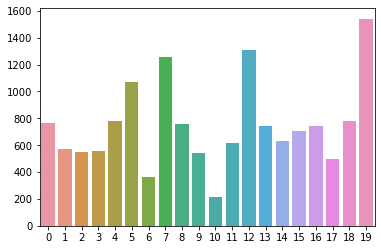

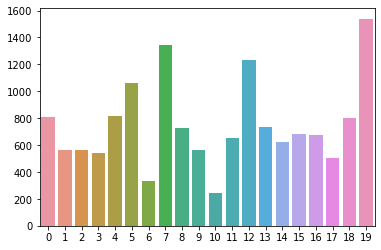

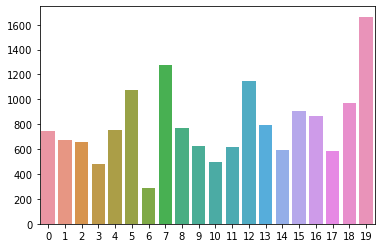

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  16000 non-null  int64
 1   behavior_id  16000 non-null  int64
dtypes: int64(2)
memory usage: 250.1 KB


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t[:,:20], axis=1)
oof_y = np.argmax(proba_oof[:,:20], axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../../data/final_data/'
sub = pd.read_csv(data_path+'submit_example.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('all_stragety-add2net%.5f.csv' % scores, index=False)
sub.info()
